In [26]:
import pyvisa as visa
from qcodes_contrib_drivers.drivers.Valon.Valon_5015 import Valon5015
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange, tqdm
from edes.modules.detection.detection_utils import plot, plot_ax, big_plt_font
from datetime import datetime
from utils import beep, V_to_P, P_to_V

big_plt_font()
rm = visa.ResourceManager()
SSA = rm.open_resource('TCPIP::192.168.169.161::INSTR')
print(SSA.query("*IDN?"))

addr = 'ASRL/dev/ttyUSB0::INSTR'
valon = Valon5015(name="Valon", address=addr)
valon.frequency(1452e6)
valon.offset(0)
valon.power(0)
valon.modulation_db(0)
valon.modulation_frequency(1)
valon.low_power_mode_enabled(True)
valon.buffer_amplifiers_enabled(False)
status = valon.status()
print(status)

base_dir = '/home/electron/artiq/experiment/artiq-master/results/npz_results'

Siglent Technologies,SSA3032X-R,SSA5PA1Q800415,3.2.2.6.0R10



KeyError: 'Another instrument has the name: Valon'

In [13]:
class RS():
    def __init__(self, ip='USB0::2733::84::104542::0::INSTR'):
        # self.inst = vxi11.Instrument(ip) 
        rm = visa.ResourceManager()
        self.inst = rm.open_resource(ip)
        # print('>>>', self.inst.ask('*IDN?')) 
        print('>>>', self.inst.query('*IDN?')) 
        self.inst.write("OUTPut OFF")
        self.inst.write("SOURce:FREQuency: MODE CW")
        # self.inst.write('SOURce:MOD:ALL:STAT ON')

    def set_freq_pwr(self, freq, power):
        self.freq = freq
        self.power = power
        inst = self.inst
        # inst.write("OUTPut OFF")
        # Channel 1
        # print(inst.ask(":OUTPut:IMPedance?"))
        inst.write("SOURce:FREQuency {:.9f}".format(self.freq))
        inst.write("SOURce:POWer:POWer {:.3f}".format(self.power))
        # inst.write("OUTPut ON")
        #print(inst.ask("OUTPUT?"))

    def set_output_on(self): 
        self.inst.write("OUTPut ON")

    def set_output_off(self): 
        self.inst.write("OUTPut OFF")

    def set_all_off(self):
        inst = self.inst
        inst.write('OUTPut OFF')
        inst.write('SOURce:MOD:ALL:STAT OFF')
        inst.close()

RS_drive = RS()

>>> Rohde&Schwarz,SMB100A,1406.6000k02/104542,3.0.13.0-2.20.382.35



In [35]:
bar = tqdm(np.arange(1.4515e9, 1.4525e9, 0.01e6))
var = {'f':0}
for freq in bar: 
    valon.frequency(freq)
    var['f'] = f'{freq/1e9:.5f}'
    bar.set_postfix(var)
    time.sleep(1)

100%|██████████████████████████████| 100/100 [01:40<00:00,  1.00s/it, f=1.45249]


In [7]:
valon.power(-3.5)

In [11]:
0.22/(180/180.95)

0.22116111111111109

In [18]:
valon.power(round(V_to_P(0.22116*2) ,5))

In [6]:
V_to_P(0.8)

np.float64(8.061799739838873)

In [7]:
(182-177)/177 * 0.238 + 0.238

0.2447231638418079

In [24]:
ON = 0
valon.buffer_amplifiers_enabled(bool(ON))

In [5]:
P_to_V(-2.5)

np.float64(0.23713737056616555)

In [84]:
round(V_to_P(0.21) ,4)

np.float64(-3.5556)

In [58]:
V_to_P(0.3)

np.float64(-0.4575749056067512)

In [15]:
P_to_V(4)

np.float64(0.5011872336272722)

In [9]:
RS_drive.set_freq_pwr(181.3*1e6*2, -15) 
RS_drive.set_output_on()

In [41]:
for P in range(-10, 3):
    RS_drive.set_freq_pwr(184.703138*1e6*2, P)
    time.sleep(3)

In [9]:
RS_drive.set_output_off()

In [18]:
RS_drive.set_all_off()

In [50]:
valon.power(round(V_to_P(0.2068),5))

In [44]:
round(V_to_P(0.20666),5), round(V_to_P(0.20665),5)

(np.float64(-3.69487), np.float64(-3.69529))

In [8]:
round(V_to_P(0.165),4)

np.float64(-5.6503)

In [41]:
V_to_P(0.158)

np.float64(-6.026858260911548)

In [31]:
V_to_P(0.5), P_to_V(-3)

(np.float64(3.979400086720376), np.float64(0.22387211385683395))

Scanning RF voltage with SSA trace reset and data taking

In [22]:
scan_min = 0.21*2 #0.25 Unit: V
scan_max = 0.23*2 #0.63 Unit: V
scan_stp = 0.001*2
cycle_time = 3
sweep_time = int((scan_max-scan_min)/scan_stp)*cycle_time*1.2

N_average = 5
SSA.write(f":SWEep:TIME {sweep_time:.1f}s")
all_data_res = []
PRS_list = [-20, -15, -10, -5]
for PRS in PRS_list:
    data_result=[]
    RS_drive.set_freq_pwr(180.95*1e6*2, PRS) 
    for n in trange(N_average):
        SSA.write(":INITiate:RESTart")
            
        # bar = tqdm(np.arange(scan_min, scan_max, scan_stp))
        bar = np.arange(scan_min, scan_max, scan_stp)
        var = {'RF Power (V)': scan_min, 'RF Power (dBm)': V_to_P(scan_min)}
        for V in bar:
            P = V_to_P(V)
            valon.power(round(P,5))
            var['RF Power (V)'] = V
            var['RF Power (dBm)'] = P
            # bar.set_postfix(var)
            time.sleep(cycle_time)
    
        time.sleep(int((scan_max-scan_min)/scan_stp)*cycle_time*0.18)
        data_str_C = SSA.query(":TRACe1:DATA?")
        
        data_arr_C = np.array([float(val) for val in data_str_C.split(',')])
        data_result.append(data_arr_C)
    all_data_res.append(data_result)

100%|█████████████████████████████████████████████| 5/5 [06:09<00:00, 73.83s/it]


In [23]:
current_datetime = datetime.now()
result_base = 'artiq/experiment/artiq-master/results/npz_results'
filename = f'{base_dir}/result_{current_datetime}.npz'
np.savez(filename, last_run_data=data_str_C, 
         full_data=data_result, scan_min=scan_min, scan_max=scan_max, 
         scan_stp=scan_stp, cycle_time=cycle_time, sweep_time=sweep_time, 
         PRS=PRS_list, all_scans=all_data_res)
print(filename)
beep()

/home/electron/artiq/experiment/artiq-master/results/npz_results/result_2025-10-10 22:56:56.677408.npz


In [47]:
current_datetime = datetime.now()
result_base = ''
filename = f'{base_dir}/result_{current_datetime}.npz'
np.savez(filename, last_run_data=data_str_C, 
         full_data=data_result, scan_min=scan_min, scan_max=scan_max, 
         scan_stp=scan_stp, cycle_time=cycle_time, sweep_time=sweep_time)
print(filename)
beep()

/home/electron/artiq/experiment/artiq-master/results/npz_results/result_2025-10-01 17:07:55.603942.npz


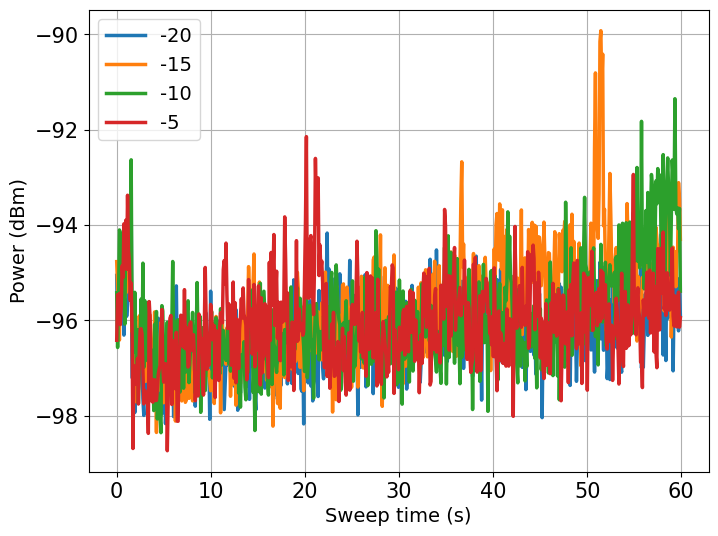

In [25]:
plt.figure(figsize=(8,6))
for i in range(len(PRS_list)):
    data_time = int((scan_max-scan_min)/scan_stp)*cycle_time
    
    # Number of points in the trace
    data_arr = 10*np.log10(np.mean([10**(i/10) for i in all_data_res[i]], axis=0))
    # noise_floor = 10*np.log10(np.mean([10**(i/10) for i in noise_result], axis=0))
    num_points = len(data_arr)
    
    # Generate frequency axis in MHz
    time_start = 0 
    time_end = sweep_time
    time_axis = np.linspace(time_start, time_end, num_points)
    actual_index = np.where(time_axis < data_time)
    time_actual = time_axis[actual_index]
    data_actual = data_arr[actual_index] 
    # noise_actual = noise_floor[actual_index]
    
    # --- Plot ---
    
    plot(time_actual, data_actual, label=PRS_list[i])
    # plot(time_actual, noise_actual, label="Laser/oven off")
plt.xlabel("Sweep time (s)")
plt.ylabel("Power (dBm)")
plt.legend()
plt.show()

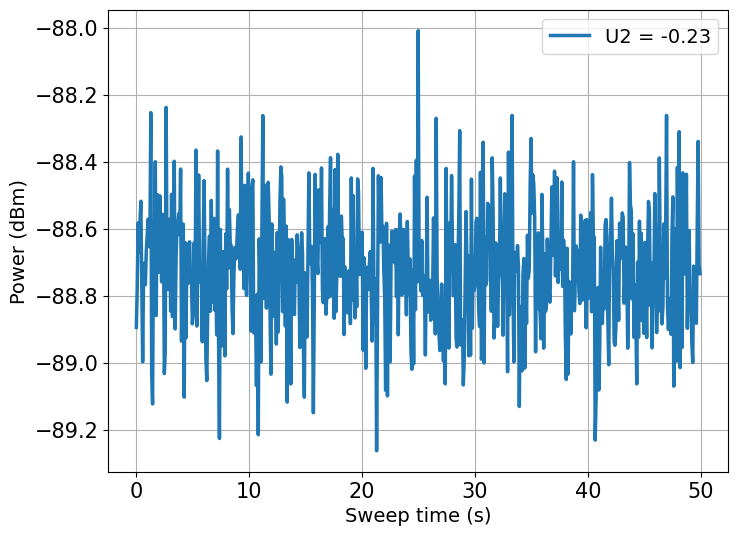

In [43]:
data_time = int((scan_max-scan_min)/scan_stp)*cycle_time

# Number of points in the trace
data_arr = 10*np.log10(np.mean([10**(i/10) for i in data_result], axis=0))
# noise_floor = 10*np.log10(np.mean([10**(i/10) for i in noise_result], axis=0))
num_points = len(data_arr)

# Generate frequency axis in MHz
time_start = 0 
time_end = sweep_time
time_axis = np.linspace(time_start, time_end, num_points)
actual_index = np.where(time_axis < data_time)
time_actual = time_axis[actual_index]
data_actual = data_arr[actual_index] 
# noise_actual = noise_floor[actual_index]

# --- Plot ---
plt.figure(figsize=(8,6))
plot(time_actual, data_actual, label="U2 = -0.23")
# plot(time_actual, noise_actual, label="Laser/oven off")
plt.xlabel("Sweep time (s)")
plt.ylabel("Power (dBm)")
plt.legend()
plt.show()

## Scan RF voltage only without taking SSA trace data

In [39]:
scan_min = 0.42 #0.25 
scan_max = 0.5 #0.63 
scan_stp = 0.003
cycle_time = 1
sweep_time = int((scan_max-scan_min)/scan_stp)*cycle_time*1.2

N_average = 1
# SSA.write(f":SWEep:TIME {sweep_time:.1f}s")
data_result=[]
for n in range(N_average):
    # SSA.write(":INITiate:RESTart")
        
    bar = tqdm(np.arange(scan_min, scan_max, scan_stp))
    # bar = np.arange(scan_min, scan_max, scan_stp)
    var = {'RF Power (V)': scan_min, 'RF Power (dBm)': V_to_P(scan_min)}
    for V in bar:
        P = round(V_to_P(V), 4)
        valon.power(P)
        # print(P)
        var['RF Power (V)'] = V
        var['RF Power (dBm)'] = P
        bar.set_postfix(var)
        time.sleep(cycle_time)

    time.sleep(int((scan_max-scan_min)/scan_stp)*cycle_time*0.18)
    # data_str_C = SSA.query(":TRACe1:DATA?")
    
    # data_arr_C = np.array([float(val) for val in data_str_C.split(',')])
    # data_result.append(data_arr_C)

100%|██| 27/27 [00:27<00:00,  1.00s/it, RF Power (V)=0.498, RF Power (dBm)=3.94]


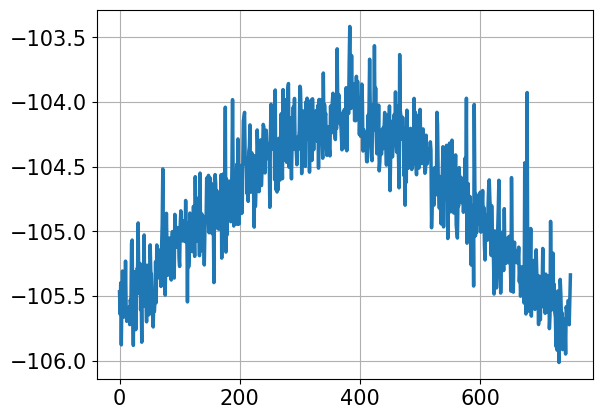

In [85]:
data_str_C = SSA.query(":TRACe2:DATA?")
data_arr_C = np.array([float(val) for val in data_str_C.split(',')])
plot(np.arange(len(data_arr_C)), data_arr_C)

In [42]:
# use for only scan no Spectrum
scan_min = 0.155 #0.25 Unit: V
scan_max = 0.165 #0.63 Unit: V
scan_stp = 0.0001
cycle_time = 1
sweep_time = int((scan_max-scan_min)/scan_stp)*cycle_time*1.2

N_average = 1
# SSA.write(f":SWEep:TIME {sweep_time:.1f}s")
data_result=[]
for n in trange(N_average):
    # SSA.write(":INITiate:RESTart")
        
    # bar = tqdm(np.arange(scan_min, scan_max, scan_stp))
    bar = np.arange(scan_min, scan_max, scan_stp)
    var = {'RF Power (V)': scan_min, 'RF Power (dBm)': V_to_P(scan_min)}
    for V in bar:
        P = V_to_P(V)
        valon.power(round(P,4))
        var['RF Power (V)'] = V
        var['RF Power (dBm)'] = P
        # bar.set_postfix(var)
        time.sleep(cycle_time)

    # time.sleep(int((scan_max-scan_min)/scan_stp)*cycle_time*0.18)
    # data_str_C = SSA.query(":TRACe1:DATA?")
    
    # data_arr_C = np.array([float(val) for val in data_str_C.split(',')])
    # data_result.append(data_arr_C)

100%|████████████████████████████████████████████| 1/1 [01:41<00:00, 101.04s/it]


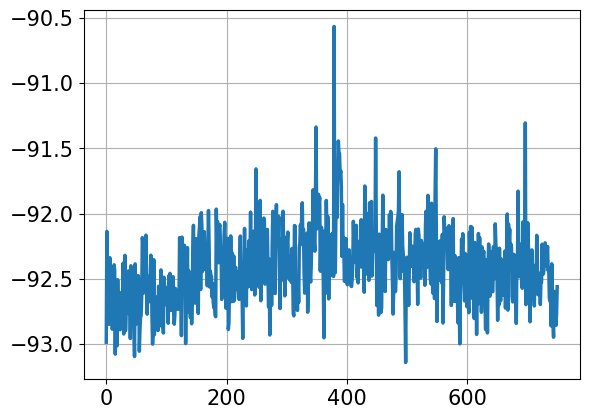

In [14]:
plot(np.arange(len(data_arr_C)), data_arr_C)


In [102]:
all_data = [] 
P_list = np.arange(-10, 10, 2)
freq_cen = 184.566138 
span = 1 
for P in tqdm(P_list): 
    RS_drive.set_freq_pwr(freq_cen*1e6*2, P)
    SSA.write(":INITiate:RESTart")
    time.sleep(7.4*11)
    data_str_C = SSA.query(":TRACe2:DATA?")
    data_arr_C = np.array([float(val) for val in data_str_C.split(',')])
    all_data.append(data_arr_C)
    time.sleep(1)
beep()

100%|███████████████████████████████████████████| 10/10 [13:44<00:00, 82.41s/it]


In [103]:
current_datetime = datetime.now()
result_base = 'artiq/experiment/artiq-master/results/npz_results'
filename = f'{base_dir}/result_{current_datetime}.npz'
np.savez(filename, last_run_data=data_str_C, 
         full_data=all_data, freq_cen=freq_cen, span=span,
         PRS=P_list, all_scans=all_data_res)
print(filename)

/home/electron/artiq/experiment/artiq-master/results/npz_results/result_2025-10-04 01:11:02.362150.npz


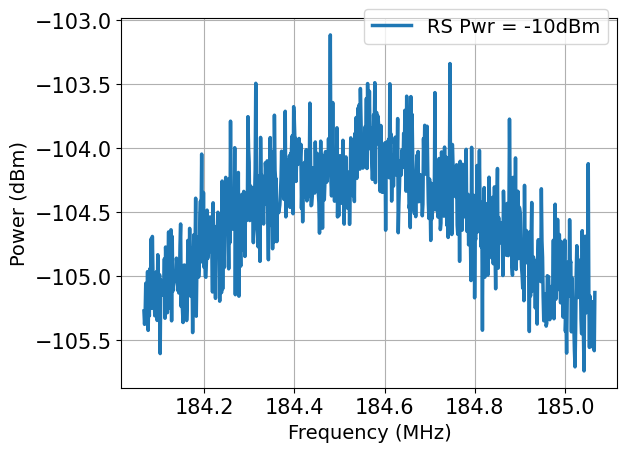

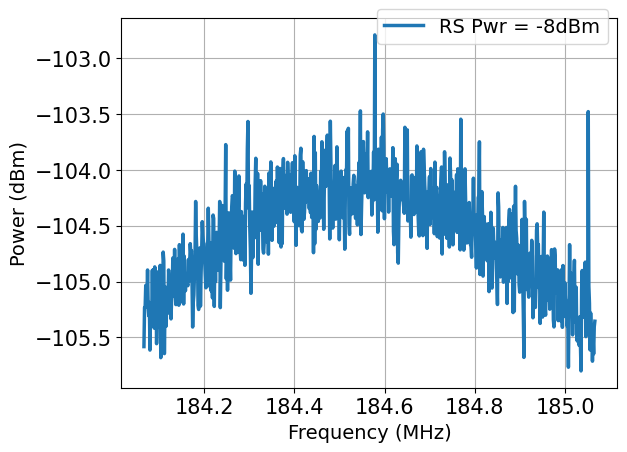

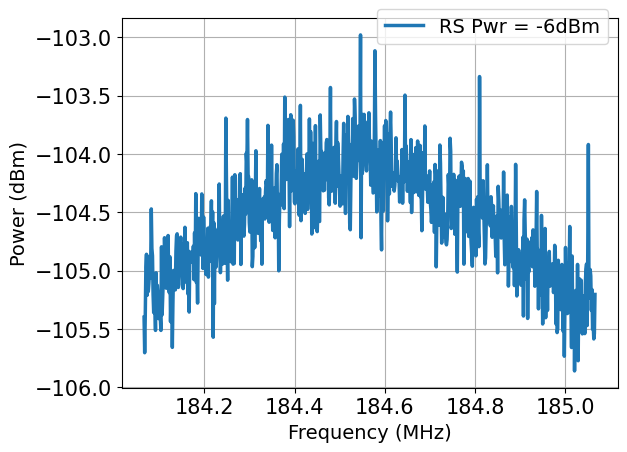

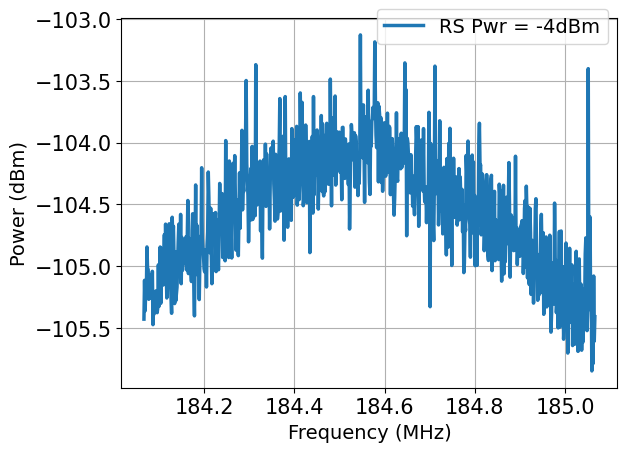

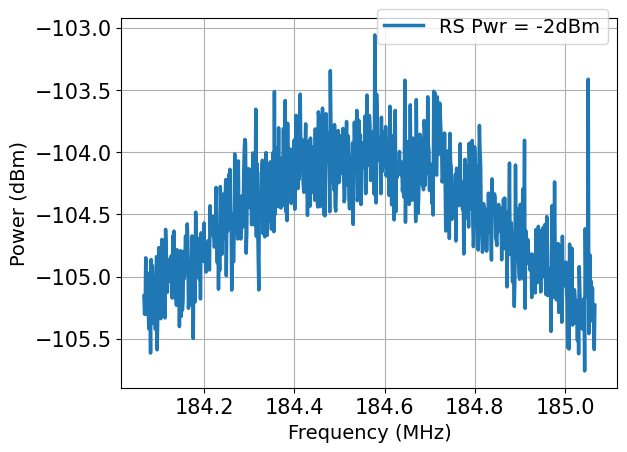

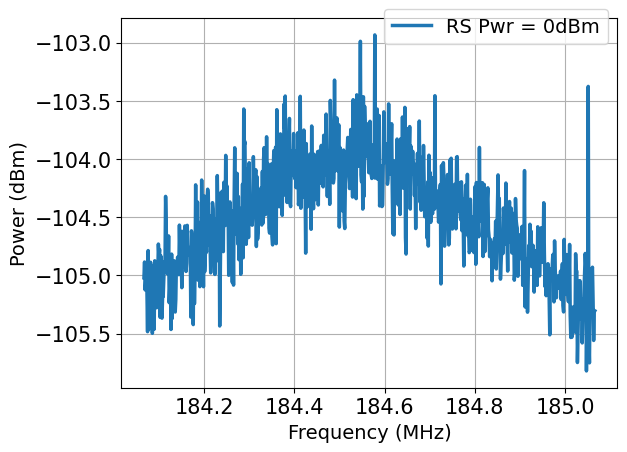

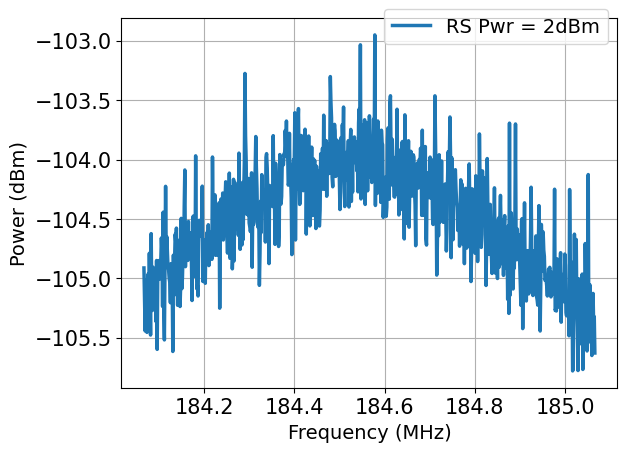

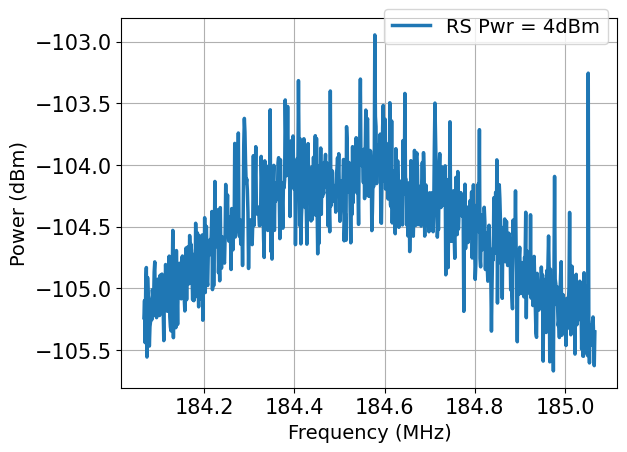

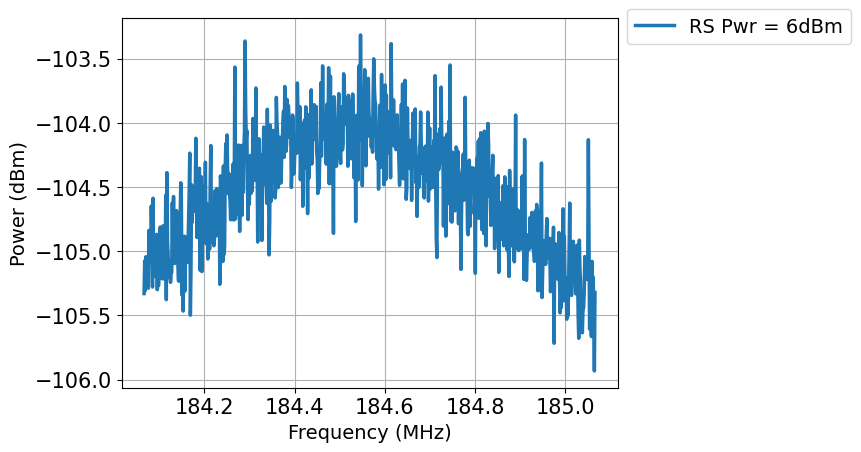

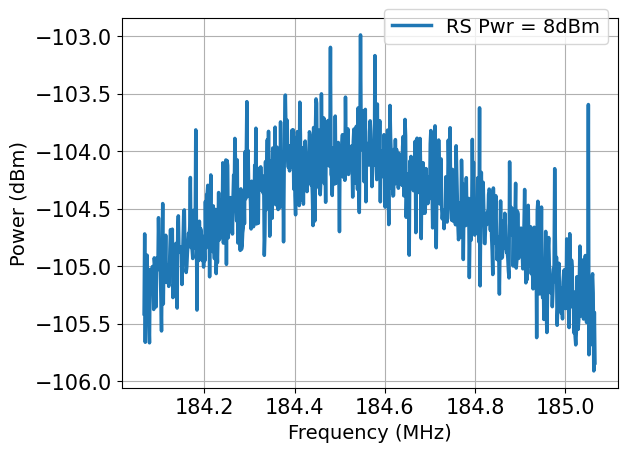

In [101]:
freq_cen = 184.566138 
span = 1 

for i in range(len(all_data)):
    fig, ax = plt.subplots()
    data = all_data[i]
    f = np.linspace(freq_cen-span/2, freq_cen+span/2, len(data))
    plot_ax(ax, f, data, label=f'RS Pwr = {P_list[i]}dBm', xlabel='Frequency (MHz)', ylabel='Power (dBm)')
    ax.legend(bbox_to_anchor=(1, 1.05))